<div class="markdown-google-sans">

# **Sarcasm Detection on News Headlines**
</div>

In [1]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
import gensim
import tensorflow as tf
import seaborn as sns


# Import required packages
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer
from sklearn.preprocessing import LabelEncoder # For label encoding
from sklearn.model_selection import train_test_split # For data partitioning
from gensim.corpora import Dictionary
from collections import Counter
from wordcloud import WordCloud # For WordCloud
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Bidirectional, SpatialDropout1D, Dropout
from keras.models import Sequential
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from transformers import pipeline
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Layer, Dense, Dropout, MultiHeadAttention, LayerNormalization, Input, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score


# Download extra packages
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

<div class="markdown-google-sans">

# **Data Dictionary**
</div>

The dataset `Sarcasm_Headlines_Dataset.json` and `Sarcasm_Headlines_Dataset_v2.json` contain headlines of the news article obtained from The Onion, an American news source. The details of the datasets are described in the table below:

- Total Number of instances: 55328
- Total Number of variables: 3

| Variable     | Description                  |
| :----------- | :--------------------------- |
| `article_link` | Link of the news article    |
| `headline`     | Headline of the news article |
| `is_sarcastic` | Take value 1 if the headline of the news article is sarcastic, otherwise 0 |



<div class="markdown-google-sans">

# **Data Understanding**
</div>

<div class="markdown-google-sans">

## **Load and Read Dataset**
</div>

In [2]:
# Load and combine datasets
df1 = pd.read_json('https://github.com/Namitt/Sentiment-Analysis-with-Sarcasm-Detection/raw/main/Sarcasm_Headlines_Dataset.json', lines = True)
df2 = pd.read_json('https://github.com/Namitt/Sentiment-Analysis-with-Sarcasm-Detection/raw/main/Sarcasm_Headlines_Dataset_v2.json', lines = True)
df = pd.concat([df1, df2])
df.reset_index(drop = True, inplace = True)

In [3]:
# Read dataset
df

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0
...,...,...,...
55323,https://www.theonion.com/jews-to-celebrate-ros...,jews to celebrate rosh hashasha or something,1
55324,https://local.theonion.com/internal-affairs-in...,internal affairs investigator disappointed con...,1
55325,https://www.huffingtonpost.com/entry/andrew-ah...,the most beautiful acceptance speech this week...,0
55326,https://www.theonion.com/mars-probe-destroyed-...,mars probe destroyed by orbiting spielberg-gat...,1


The summary statistics below helps better understand the dataset.

In [4]:
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [5]:
df.groupby('is_sarcastic').describe().T

is_sarcastic                                                         0  \
article_link count                                               29970   
             unique                                              14984   
             top     https://www.huffingtonpost.comhttp://nymag.com...   
             freq                                                    4   
headline     count                                               29970   
             unique                                              14951   
             top                                        sunday roundup   
             freq                                                   20   

is_sarcastic                                                         1  
article_link count                                               25358  
             unique                                              13633  
             top     https://politics.theonion.com/nation-not-sure-...  
             freq                                                    3  
headline     count                                               25358  
             unique                                              13552  
             top     'no way to prevent this,' says only nation whe...  
             freq                                                   20

We observe the distribution of sarcastic and non-sarcastic headlines in the dataset.

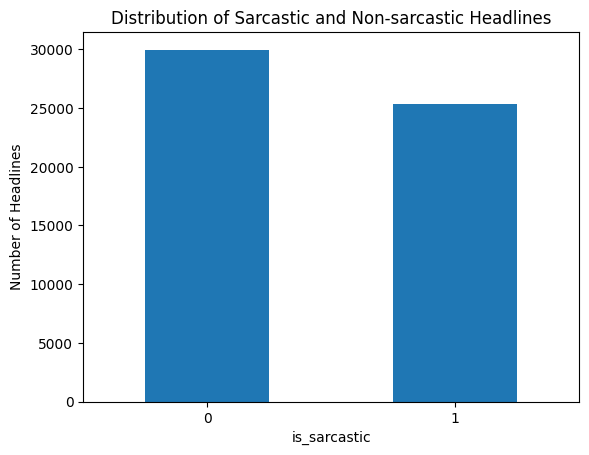

is_sarcastic
0    29970
1    25358
Name: count, dtype: int64

In [6]:
# Visualise the data after undersampling
df['is_sarcastic'].value_counts().plot(kind = 'bar', title = 'Distribution of Sarcastic and Non-sarcastic Headlines')
plt.xlabel('is_sarcastic')
plt.ylabel('Number of Headlines')
plt.xticks(rotation = 0)
plt.show()

# Distribution of sarcastic and non-sarcastic headlines
df['is_sarcastic'].value_counts()

After observing the distribution, we decide to use the full dataset without performing data balancing.